# AnoGAN  
- tensorflow로 구현

In [1]:
# packages and modules
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dense, Reshape, Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [5]:
# load data
path = './anogan_carpet/train'

def load_image(path):
    files = glob.glob(path+'./**/*.png')
    image_list = []
    for file in files:
        img = Image.open(file).convert('L')
        img = img.resize((128,128))
        img = np.asarray(img).astype('float32')
        image_list.append(img)
    image_list = (np.array(image_list)-127.5)/127.5
    return image_list

data = load_image(path)

In [6]:
# create mini batch dataset
latent_dim = 128
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(100)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## Build Models

In [7]:
# define generator model
class Generator(Model):
    def __init__(self, latent_dim=128, num_filters=32, out_channel=1):
        super(Generator, self).__init__()
        init = RandomNormal(mean=0.0, stddev=0.02)
        self.g_model = Sequential([
            # input size: 128
            Dense(8*8*512, input_shape=[latent_dim,], use_bias=False),
            BatchNormalization(),
            LeakyReLU(0.2),
            Reshape([8,8,512]),
            # output size: 8x8x512
            
            Conv2DTranspose(num_filters*8, (4,4), strides=2, padding='same', 
                            kernel_initializer=init, use_bias=False),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 16x16x256
            
            Conv2DTranspose(num_filters*4, (4,4), strides=2, padding='same',
                            kernel_initializer=init, use_bias=False),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 32x32x128
            
            Conv2DTranspose(num_filters*2, (4,4), strides=2, padding='same', 
                            kernel_initializer=init, use_bias=False),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 64x64x64
            
            Conv2DTranspose(out_channel, (4,4), strides=2, padding='same', 
                            kernel_initializer=init, use_bias=False),
            Activation('tanh')
            # output size: 128x128x1
        ])
        
    def call(self, x):
        return self.g_model(x)

In [8]:
class Discriminator(Model):
    def __init__(self, input_shape=(128,128,1), num_filters=32):
        super(Discriminator, self).__init__()
        init = RandomNormal(mean=0.0, stddev=0.02)
        self.feature_extractor = Sequential([
            # input size: 128x128x1
            Conv2D(num_filters, (4,4), strides=2, padding='same', kernel_initializer=init, 
                   input_shape=input_shape),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 64x64x64
            
            Conv2D(num_filters*2, (4,4), strides=2, padding='same', kernel_initializer=init),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 32x32x128
            
            Conv2D(num_filters*4, (4,4), strides=2, padding='same', kernel_initializer=init),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 16x16x256
            
            Conv2D(num_filters*8, (4,4), strides=2, padding='same', kernel_initializer=init),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 8x8x512
            
            Conv2D(num_filters*16, (4,4), strides=2, padding='same', kernel_initializer=init),
            BatchNormalization(),
            LeakyReLU(0.2),
            # output size: 4x4x1024
        ])
        self.classifier = Sequential([
            Flatten(),
            Dropout(0.2),
            Dense(1, kernel_initializer=init, activation='sigmoid')
        ])
        
    def extract_feature(self, x):
        return self.feature_extractor(x)
    
    def call(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [9]:
# load model
generator = Generator()
discriminator = Discriminator()

## Set losses and optimizers

In [10]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

gen_optim = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)
dis_optim = Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2)

In [11]:
bce_loss = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_label = tf.ones_like(real_output)
    real_loss = bce_loss(real_label, real_output)
    fake_label = tf.zeros_like(fake_output)
    fake_loss = bce_loss(fake_label, fake_output)
    return real_loss+fake_loss

def generator_loss(dis_output):
    gen_label = tf.ones_like(dis_output)
    loss = bce_loss(gen_label, dis_output)
    return loss

In [12]:
img_normal = lambda img: (img+1)/2

def plot_generated_images(fake_images, epoch, every):
    if epoch%every==0:
        plt.figure(figsize=(10,4))
        for i in range(10):
            plt.subplot(2,5,i+1)
            plt.imshow(img_normal(fake_images[i]), cmap='gray')
            plt.axis('off')
        plt.show()

## Traing DCGAN

In [13]:
n_epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

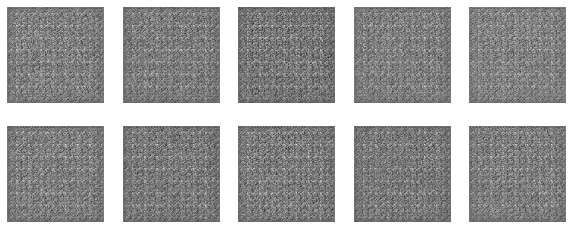

Epoch 1/100, time: 3.9084s
Discriminator loss: 1.291, Generator loss: 0.92517
----------------------------------------------------
Epoch 2/100, time: 0.92245s
Discriminator loss: 0.41672, Generator loss: 3.398
----------------------------------------------------
Epoch 3/100, time: 0.91245s
Discriminator loss: 0.17484, Generator loss: 4.3175
----------------------------------------------------
Epoch 4/100, time: 0.91318s
Discriminator loss: 0.72216, Generator loss: 1.1287
----------------------------------------------------
Epoch 5/100, time: 0.97641s
Discriminator loss: 0.10268, Generator loss: 5.2305
----------------------------------------------------
Epoch 6/100, time: 0.91461s
Discriminator loss: 0.43672, Generator loss: 3.2368
----------------------------------------------------
Epoch 7/100, time: 0.91247s
Discriminator loss: 0.8613, Generator loss: 0.95822
----------------------------------------------------
Epoch 8/100, time: 0.90344s
Discriminator loss: 0.57747, Generator loss:

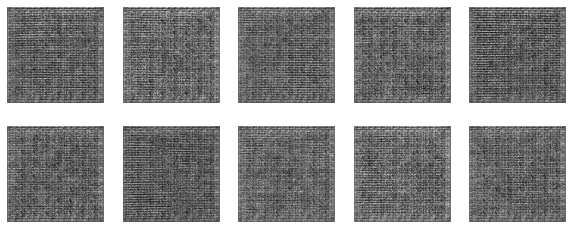

Epoch 11/100, time: 0.92182s
Discriminator loss: 0.24505, Generator loss: 3.9729
----------------------------------------------------
Epoch 12/100, time: 1.0075s
Discriminator loss: 0.47396, Generator loss: 1.934
----------------------------------------------------
Epoch 13/100, time: 0.96661s
Discriminator loss: 0.56271, Generator loss: 1.5664
----------------------------------------------------
Epoch 14/100, time: 0.96108s
Discriminator loss: 0.89504, Generator loss: 1.2587
----------------------------------------------------
Epoch 15/100, time: 0.94525s
Discriminator loss: 0.23054, Generator loss: 2.5698
----------------------------------------------------
Epoch 16/100, time: 0.95658s
Discriminator loss: 0.20947, Generator loss: 4.0683
----------------------------------------------------
Epoch 17/100, time: 0.96096s
Discriminator loss: 0.24478, Generator loss: 1.7959
----------------------------------------------------
Epoch 18/100, time: 0.95276s
Discriminator loss: 0.21542, Genera

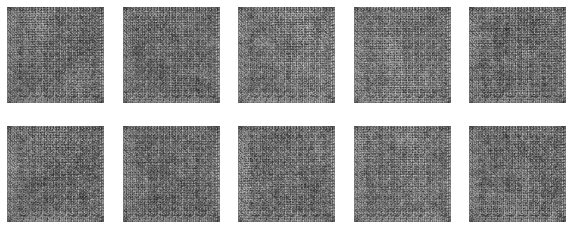

Epoch 21/100, time: 0.96458s
Discriminator loss: 0.16587, Generator loss: 3.0264
----------------------------------------------------
Epoch 22/100, time: 0.95469s
Discriminator loss: 0.41192, Generator loss: 5.0401
----------------------------------------------------
Epoch 23/100, time: 0.89045s
Discriminator loss: 0.60679, Generator loss: 7.6749
----------------------------------------------------
Epoch 24/100, time: 0.89407s
Discriminator loss: 0.84344, Generator loss: 7.3964
----------------------------------------------------
Epoch 25/100, time: 0.95101s
Discriminator loss: 0.15612, Generator loss: 3.3262
----------------------------------------------------
Epoch 26/100, time: 0.90817s
Discriminator loss: 0.7303, Generator loss: 2.5377
----------------------------------------------------
Epoch 27/100, time: 0.92516s
Discriminator loss: 1.4121, Generator loss: 4.5871
----------------------------------------------------
Epoch 28/100, time: 0.90287s
Discriminator loss: 0.71808, Genera

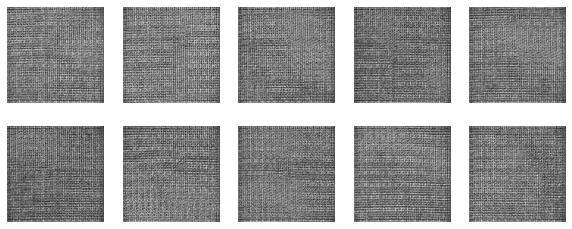

Epoch 31/100, time: 0.96208s
Discriminator loss: 0.5861, Generator loss: 1.6465
----------------------------------------------------
Epoch 32/100, time: 0.91257s
Discriminator loss: 0.50447, Generator loss: 2.6543
----------------------------------------------------
Epoch 33/100, time: 0.9445s
Discriminator loss: 0.30936, Generator loss: 3.3514
----------------------------------------------------
Epoch 34/100, time: 0.95006s
Discriminator loss: 0.25252, Generator loss: 3.5717
----------------------------------------------------
Epoch 35/100, time: 0.95368s
Discriminator loss: 0.18931, Generator loss: 3.1342
----------------------------------------------------
Epoch 36/100, time: 0.94284s
Discriminator loss: 0.36569, Generator loss: 3.114
----------------------------------------------------
Epoch 37/100, time: 0.94231s
Discriminator loss: 0.34419, Generator loss: 1.6921
----------------------------------------------------
Epoch 38/100, time: 0.93539s
Discriminator loss: 0.39384, Generat

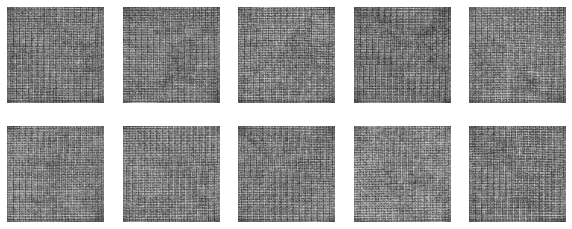

Epoch 41/100, time: 0.93968s
Discriminator loss: 0.12521, Generator loss: 3.8731
----------------------------------------------------
Epoch 42/100, time: 0.90932s
Discriminator loss: 0.43968, Generator loss: 3.8071
----------------------------------------------------
Epoch 43/100, time: 0.93905s
Discriminator loss: 0.47728, Generator loss: 3.419
----------------------------------------------------
Epoch 44/100, time: 0.90891s
Discriminator loss: 0.66352, Generator loss: 3.2754
----------------------------------------------------
Epoch 45/100, time: 0.97186s
Discriminator loss: 0.20341, Generator loss: 2.9491
----------------------------------------------------
Epoch 46/100, time: 0.88425s
Discriminator loss: 0.55801, Generator loss: 4.6986
----------------------------------------------------
Epoch 47/100, time: 0.91979s
Discriminator loss: 1.9211, Generator loss: 0.29101
----------------------------------------------------
Epoch 48/100, time: 0.92524s
Discriminator loss: 1.1101, Genera

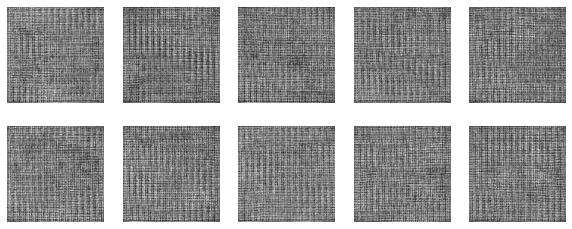

Epoch 51/100, time: 0.95441s
Discriminator loss: 0.29119, Generator loss: 3.4535
----------------------------------------------------
Epoch 52/100, time: 0.95254s
Discriminator loss: 0.33093, Generator loss: 2.9724
----------------------------------------------------
Epoch 53/100, time: 0.8799s
Discriminator loss: 0.69256, Generator loss: 1.4773
----------------------------------------------------
Epoch 54/100, time: 0.88702s
Discriminator loss: 0.72189, Generator loss: 5.0915
----------------------------------------------------
Epoch 55/100, time: 0.88188s
Discriminator loss: 0.25471, Generator loss: 3.4505
----------------------------------------------------
Epoch 56/100, time: 0.89466s
Discriminator loss: 0.45896, Generator loss: 1.8177
----------------------------------------------------
Epoch 57/100, time: 0.87966s
Discriminator loss: 0.16408, Generator loss: 3.2697
----------------------------------------------------
Epoch 58/100, time: 0.89841s
Discriminator loss: 1.3357, Genera

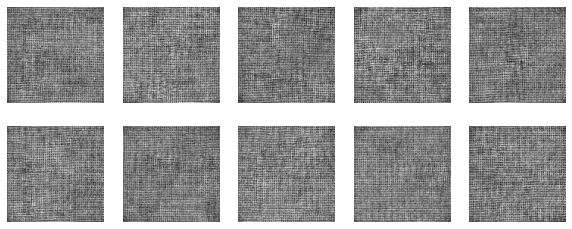

Epoch 61/100, time: 0.93308s
Discriminator loss: 1.6395, Generator loss: 0.53945
----------------------------------------------------
Epoch 62/100, time: 0.94707s
Discriminator loss: 0.51504, Generator loss: 4.3984
----------------------------------------------------
Epoch 63/100, time: 0.87612s
Discriminator loss: 0.13654, Generator loss: 3.9186
----------------------------------------------------
Epoch 64/100, time: 0.91095s
Discriminator loss: 0.26954, Generator loss: 5.6994
----------------------------------------------------
Epoch 65/100, time: 0.8887s
Discriminator loss: 0.16886, Generator loss: 3.5417
----------------------------------------------------
Epoch 66/100, time: 0.88411s
Discriminator loss: 0.37528, Generator loss: 3.7259
----------------------------------------------------
Epoch 67/100, time: 0.89866s
Discriminator loss: 0.53208, Generator loss: 1.7362
----------------------------------------------------
Epoch 68/100, time: 0.88158s
Discriminator loss: 0.49506, Gener

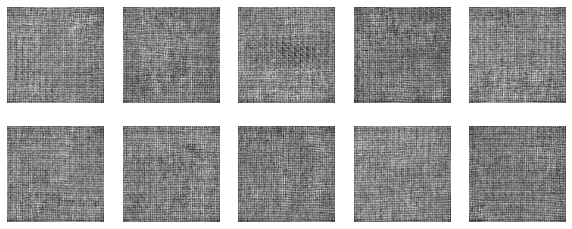

Epoch 71/100, time: 0.95424s
Discriminator loss: 0.18181, Generator loss: 5.1837
----------------------------------------------------
Epoch 72/100, time: 0.93255s
Discriminator loss: 0.22159, Generator loss: 2.2862
----------------------------------------------------
Epoch 73/100, time: 0.93887s
Discriminator loss: 0.079284, Generator loss: 4.7441
----------------------------------------------------
Epoch 74/100, time: 0.90203s
Discriminator loss: 0.096329, Generator loss: 3.7177
----------------------------------------------------
Epoch 75/100, time: 0.88098s
Discriminator loss: 0.14349, Generator loss: 3.186
----------------------------------------------------
Epoch 76/100, time: 0.87806s
Discriminator loss: 0.046997, Generator loss: 4.554
----------------------------------------------------
Epoch 77/100, time: 0.89282s
Discriminator loss: 0.15167, Generator loss: 2.8876
----------------------------------------------------
Epoch 78/100, time: 0.9074s
Discriminator loss: 0.20537, Gene

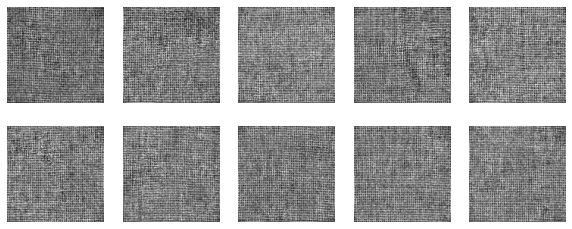

Epoch 81/100, time: 0.90436s
Discriminator loss: 0.21929, Generator loss: 4.1453
----------------------------------------------------
Epoch 82/100, time: 0.89445s
Discriminator loss: 0.19788, Generator loss: 4.5429
----------------------------------------------------
Epoch 83/100, time: 0.91824s
Discriminator loss: 0.060896, Generator loss: 5.8434
----------------------------------------------------
Epoch 84/100, time: 0.91749s
Discriminator loss: 0.11035, Generator loss: 3.3218
----------------------------------------------------
Epoch 85/100, time: 0.94458s
Discriminator loss: 0.080447, Generator loss: 4.4456
----------------------------------------------------
Epoch 86/100, time: 0.96494s
Discriminator loss: 0.082673, Generator loss: 6.0061
----------------------------------------------------
Epoch 87/100, time: 0.93814s
Discriminator loss: 0.04037, Generator loss: 4.0753
----------------------------------------------------
Epoch 88/100, time: 0.95413s
Discriminator loss: 0.050904, 

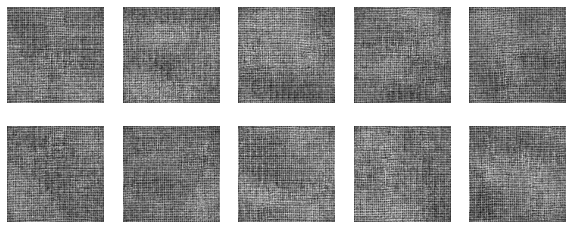

Epoch 91/100, time: 0.96556s
Discriminator loss: 0.19111, Generator loss: 3.4234
----------------------------------------------------
Epoch 92/100, time: 0.97275s
Discriminator loss: 0.63508, Generator loss: 5.5387
----------------------------------------------------
Epoch 93/100, time: 0.9483s
Discriminator loss: 0.12608, Generator loss: 3.449
----------------------------------------------------
Epoch 94/100, time: 0.9522s
Discriminator loss: 0.065493, Generator loss: 3.5917
----------------------------------------------------
Epoch 95/100, time: 0.95609s
Discriminator loss: 0.085475, Generator loss: 4.7013
----------------------------------------------------
Epoch 96/100, time: 0.965s
Discriminator loss: 0.043107, Generator loss: 4.2232
----------------------------------------------------
Epoch 97/100, time: 0.95491s
Discriminator loss: 0.097293, Generator loss: 3.9432
----------------------------------------------------
Epoch 98/100, time: 0.96201s
Discriminator loss: 0.079969, Gene

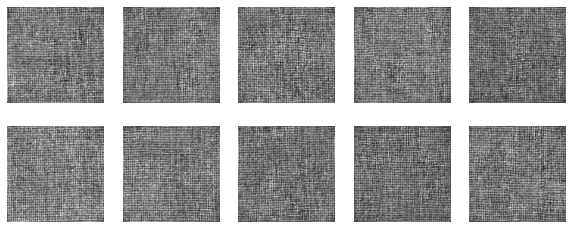

Total time for training is 98.18751239776611s


In [14]:
d_loss_list, g_loss_list = [], []
start_time = time.time()
for epoch in tqdm(range(n_epochs)):
    initial_epoch = time.time()
    for X_batch in dataset:
        # 랜덤 노이즈 생성
        z = tf.random.normal((batch_size, latent_dim))
        with tf.GradientTape() as dis_tape, tf.GradientTape() as gen_tape:
            X_real = X_batch
            # step1: 가짜 이미지 생성
            X_fake = generator(z, training=True)
            # step2: 진짜 이미지와 가짜 이미지를 판별자에 입력
            real_output = discriminator(X_batch, training=True)
            fake_output = discriminator(X_fake, training=True)
            # step3: 로스 구하기
            g_loss = generator_loss(fake_output)
            d_loss = discriminator_loss(real_output, fake_output)
        # update loss
        dis_grad = dis_tape.gradient(d_loss, discriminator.trainable_variables)
        gen_grad = gen_tape.gradient(g_loss, generator.trainable_variables)
        # update optimizer
        dis_optim.apply_gradients(zip(dis_grad, discriminator.trainable_variables))
        gen_optim.apply_gradients(zip(gen_grad, generator.trainable_variables))
        
    if (epoch+1)==1:
        plot_generated_images(X_fake, epoch+1, epoch+1)
        
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)
    end_epoch = time.time()
    print(f'Epoch {epoch+1}/{n_epochs}, time: {end_epoch-initial_epoch:.5}s\n'
          f'Discriminator loss: {d_loss:.5}, Generator loss: {g_loss:.5}')
    print('----------------------------------------------------')
    # show fake image
    plot_generated_images(X_fake, epoch+1, 10)
end_time = time.time()
print(f'Total time for training is {end_time-start_time}s')

In [15]:
# 모델 weights 저장
generator.save_weights('./model_weights/carpet_generator.h5')
discriminator.save_weights('./model_weights/carpet_discriminator.h5')

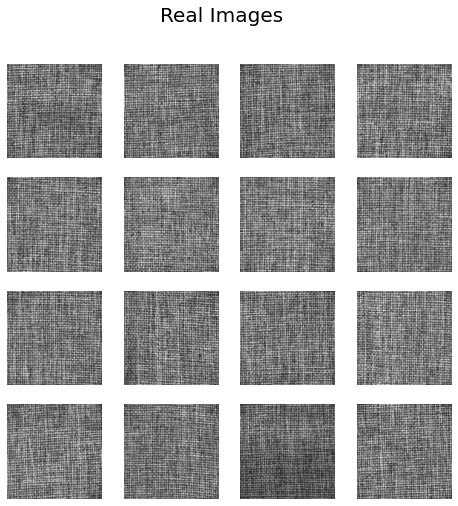

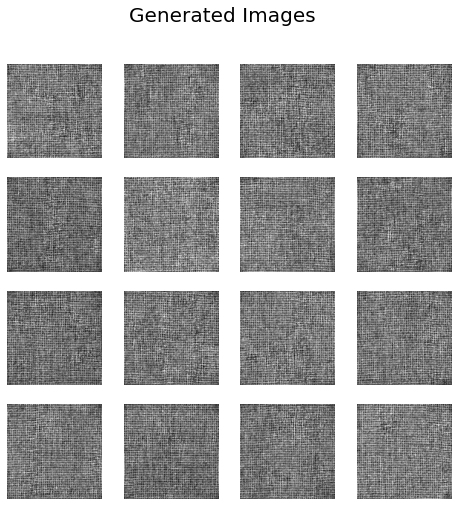

In [16]:
# compare with real images and generated images
# real images
fig, ax = plt.subplots(4,4, figsize=(8,8))
fig.suptitle('Real Images', fontsize=20)
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.imshow(img_normal(X_real[i]), cmap='gray')
    plt.axis('off')
plt.show()

# generated images
fig, ax = plt.subplots(4,4, figsize=(8,8))
fig.suptitle('Generated Images', fontsize=20)
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.imshow(img_normal(X_fake[i]), cmap='gray')
    plt.axis('off')
plt.show()

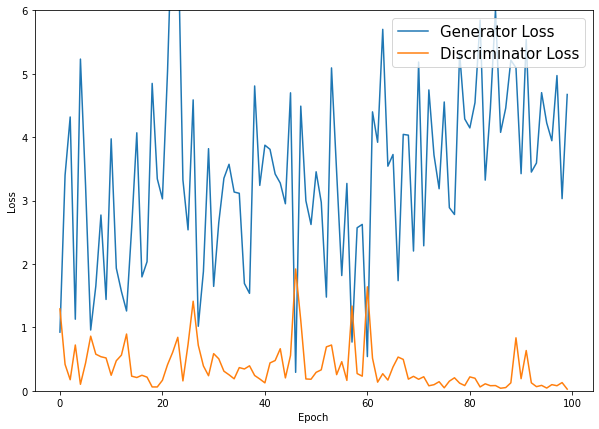

In [17]:
# check losses of networks
plt.figure(figsize=(10,7))
plt.plot(g_loss_list, label='Generator Loss')
plt.plot(d_loss_list, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize=15)
plt.ylim(0,6)
plt.show()

## Train Z vector

In [20]:
# load test path (only normal) and anomaly path (only anomaly)
test_path = './anogan_carpet_target/'
z_batch_size = 1

test_set = load_image(test_path)
test_set = tf.data.Dataset.from_tensor_slices(test_set).shuffle(100)
test_set = test_set.batch(z_batch_size, drop_remainder=True).prefetch(1)

In [18]:
# z를 훈련하기 위해 generator 전체와 discriminator의 extractor fmap을 호출 (weights도 호출)
z_generator = Generator()
z_generator.built = True
z_generator.load_weights('./model_weights/carpet_generator.h5')

z_discriminator = Discriminator()
z_discriminator.built = True
z_discriminator.build((None,128,128,1))
z_discriminator.load_weights('./model_weights/carpet_discriminator.h5')
z_extract_fmap = Model(inputs=z_discriminator.layers[0].input, 
                       outputs=z_discriminator.layers[-2].output)

z_optimizer = Adam(learning_rate=lr)

In [57]:
# define losses
def residual_loss(real_image, fake_image):
    loss = real_image-fake_image
    return tf.reduce_sum(tf.abs(loss))

def discrimination_loss(real_image, fake_image):
    y_real = discriminator.extract_feature(real_image)
    y_fake = discriminator.extract_feature(fake_image)
    return tf.reduce_sum(tf.abs(y_real-y_fake))

def anomaly_loss(residual_loss, discrimination_loss, lambda_=0.1):
    loss = (1-lambda_)*residual_loss + lambda_*(discrimination_loss)
    return tf.reduce_sum(loss)

In [23]:
# latent vector z를 훈련시키는 함수 정의
def train_latent_space(dataset):
    z = tf.random.normal((z_batch_size, latent_dim))
    
    latent_space, anomaly_score = [], []
    
    for i, real_image in tqdm(enumerate(dataset)):
        for step in range(1000):
            with tf.GradientTape() as tape:
                # step1: 가짜 이미지 생성
                fake_image = z_generator(z)
                # step2: loss 구하기
                res_loss = residual_loss(real_image, fake_image)
                dis_loss = discrimination_loss(real_image, fake_image)
                ano_loss = anomaly_loss(res_loss, dis_loss, lambda_=0.1)
            # step3: loss 및 optimizer 업데이트
            z_grad = tape.gradient(ano_loss, z_generator.trainable_variables)
            z_optimizer.apply_gradients(zip(z_grad, z_generator.trainable_variables))
        print(f'{i+1} image, step [{step+1}]\n'
              f'residual loss: {res_loss:.5},  '
              f'discrimination loss: {dis_loss:.5},  '
              f'anomaly loss: {ano_loss:.5}')
        latent_space.append(z)
        anomaly_score.append(ano_loss)
    return np.array(latent_space), np.array(anomaly_score)

In [24]:
latent_space, anomaly_score = train_latent_space(test_set)

0it [00:00, ?it/s]

1 image, step [1000]
residual loss: 3.0664e+05,  discrimination loss: 1.0939e+04,  anomaly loss: 2.7707e+05
2 image, step [1000]
residual loss: 3.1116e+05,  discrimination loss: 1.0824e+04,  anomaly loss: 2.8112e+05
3 image, step [1000]
residual loss: 2.9156e+05,  discrimination loss: 1.0479e+04,  anomaly loss: 2.6345e+05
4 image, step [1000]
residual loss: 3.4625e+05,  discrimination loss: 1.0323e+04,  anomaly loss: 3.1266e+05
5 image, step [1000]
residual loss: 2.8943e+05,  discrimination loss: 1.0549e+04,  anomaly loss: 2.6154e+05
6 image, step [1000]
residual loss: 2.8212e+05,  discrimination loss: 1.0249e+04,  anomaly loss: 2.5494e+05
7 image, step [1000]
residual loss: 3.2769e+05,  discrimination loss: 1.0949e+04,  anomaly loss: 2.9602e+05
8 image, step [1000]
residual loss: 3.2697e+05,  discrimination loss: 1.0314e+04,  anomaly loss: 2.953e+05
9 image, step [1000]
residual loss: 3.1928e+05,  discrimination loss: 7924.5,  anomaly loss: 2.8814e+05
10 image, step [1000]
residual lo

In [25]:
latent_space = np.array(latent_space)
anomaly_score = np.array(anomaly_score)

In [58]:
def compute_anomaly_score(input_image, z):
    fake_image = generator(z)
    res_loss = residual_loss(input_image, fake_image)
    dis_loss = discriminator_loss(input_image, fake_image)
    ano_score = anomaly_loss(res_loss, dis_loss, lambda_=0.1)
    return ano_score, fake_image

In [59]:
def img_normal(image, add=False):
    if add==False:
        img = (image+1)/2
    else:
        img = (image-tf.reduce_min(image))/tf.reduce_max((image-tf.reduce_min(image)))
    return img

In [63]:
def compare_images(input_image, z):
    score, fake_image = compute_anomaly_score(input_image, z)
    
    real_image = tf.reshape(input_image, (128,128,1))
    fake_image = tf.reshape(fake_image, (128,128,1))
        
    diff_image = real_image-fake_image
    
    anomaly_image = np.zeros(shape=(128,128,1))
    anomaly_image[:,:,0] = diff_image[:,:,0]
    
    fig, ax = plt.subplots(1,4, figsize=(15,4))
    fig.suptitle(f'Anomaly score {score:.6}', size=20)
    ax[0].imshow(img_normal(real_image), cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Input Image')
    ax[1].imshow(img_normal(fake_image), cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Generated Image')
    ax[2].imshow(img_normal(diff_image, add=True), cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('Difference')
    ax[3].imshow(img_normal(anomaly_image, add=True), cmap='gray')
    ax[3].axis('off')
    ax[3].set_title('Anomaly Image')
    fig.show()

In [64]:
def show_image_score(dataset, latent_z):
    for i, image in enumerate(dataset):
        update_z = latent_z[i]
        compare_images(image, update_z)

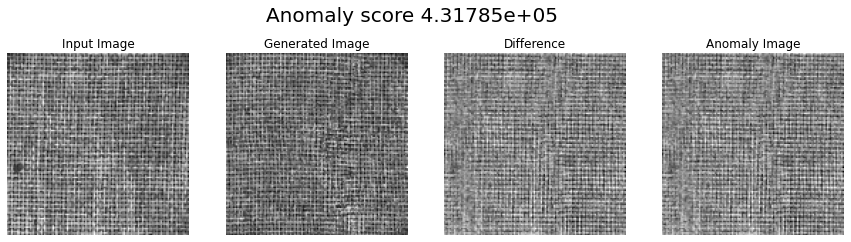

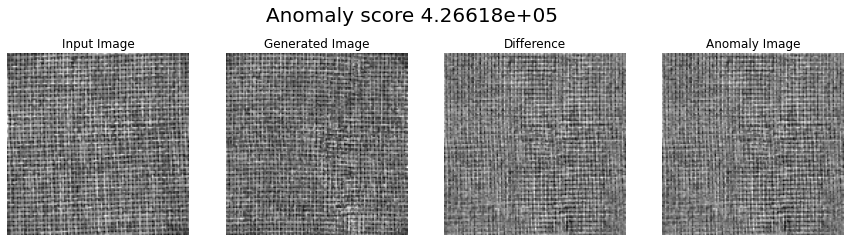

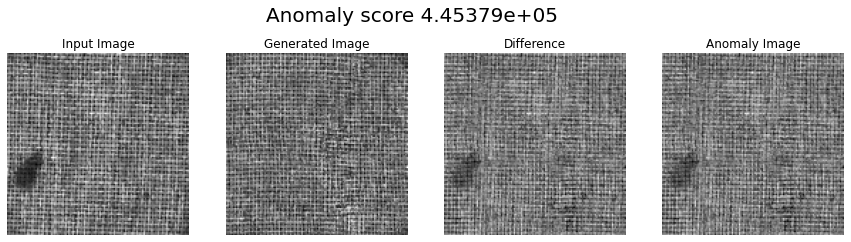

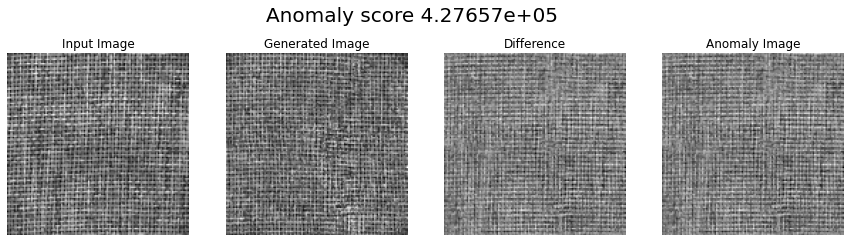

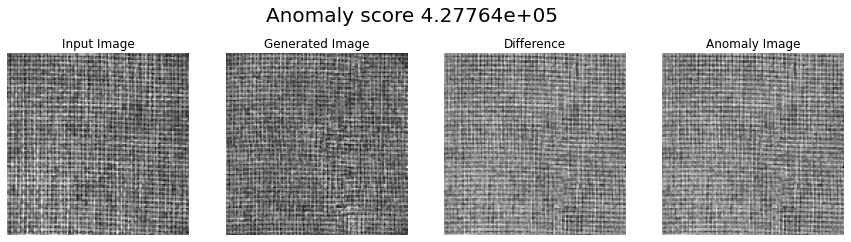

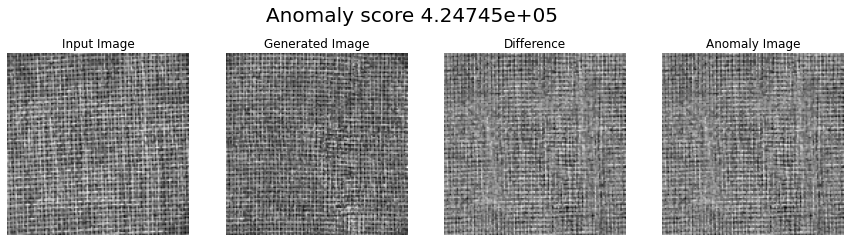

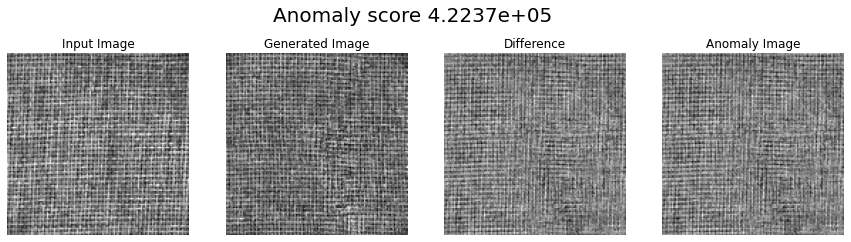

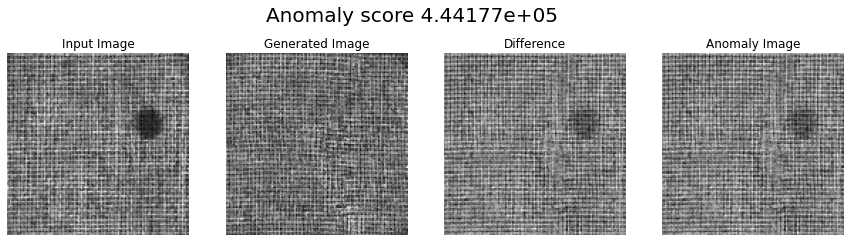

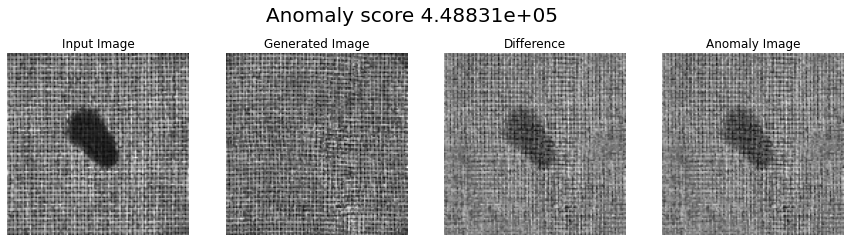

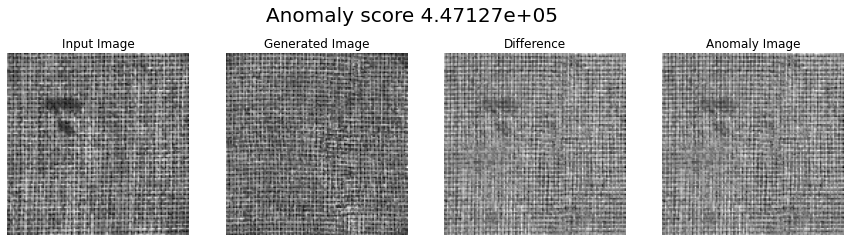

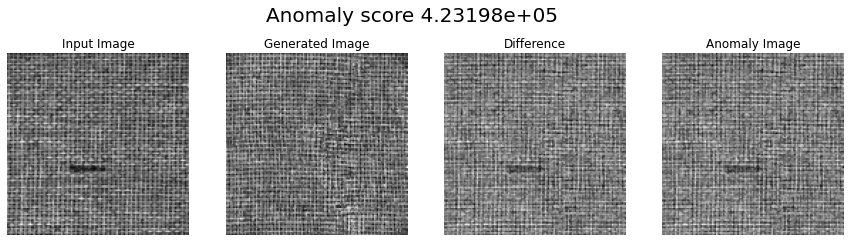

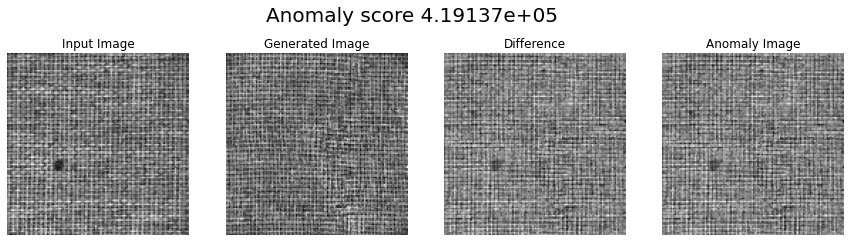

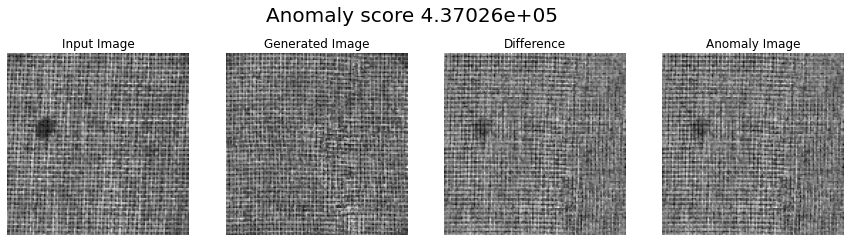

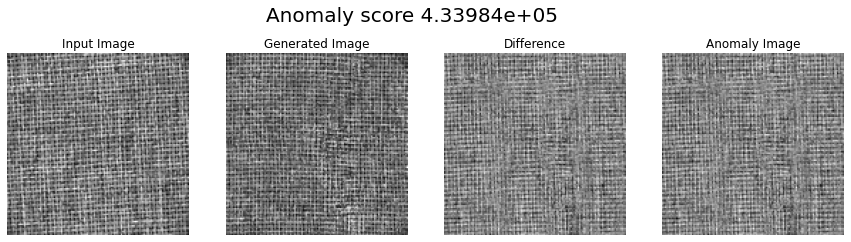

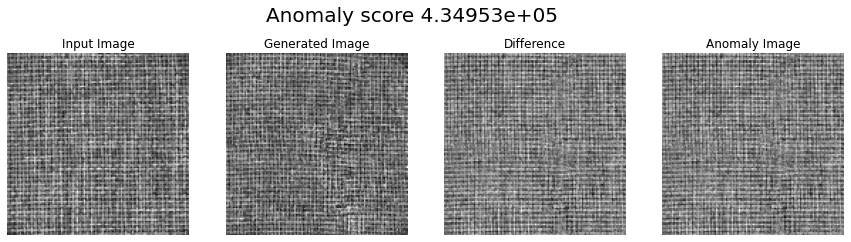

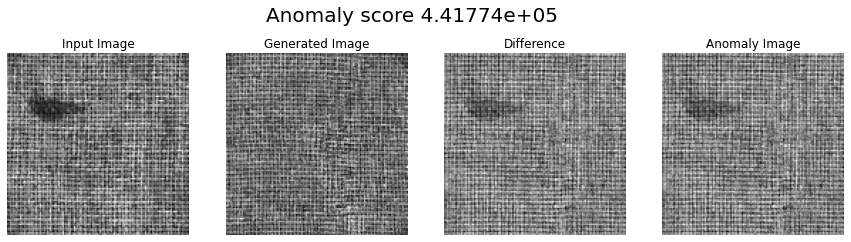

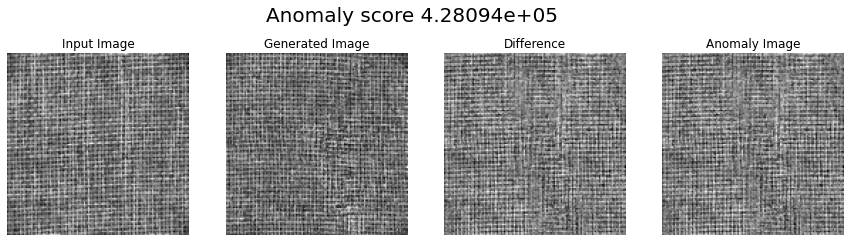

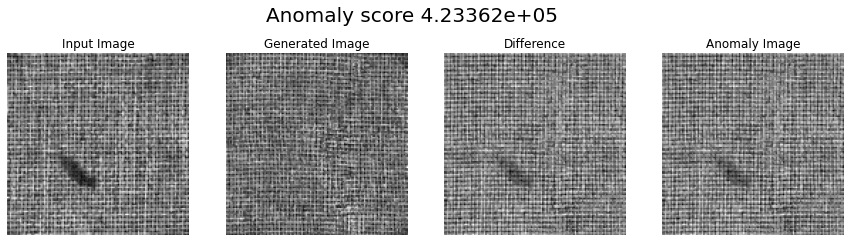

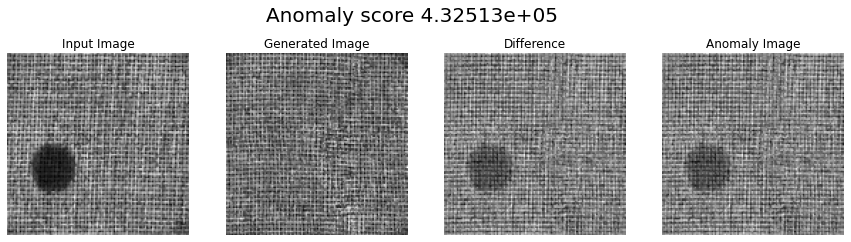

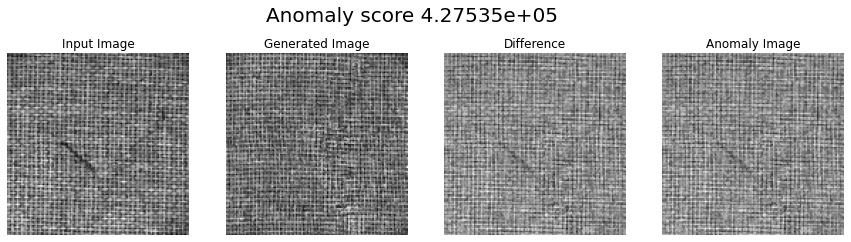

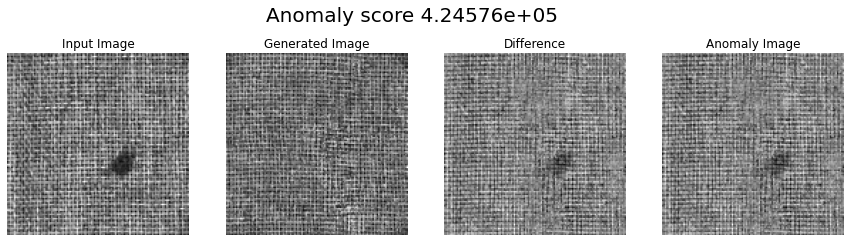

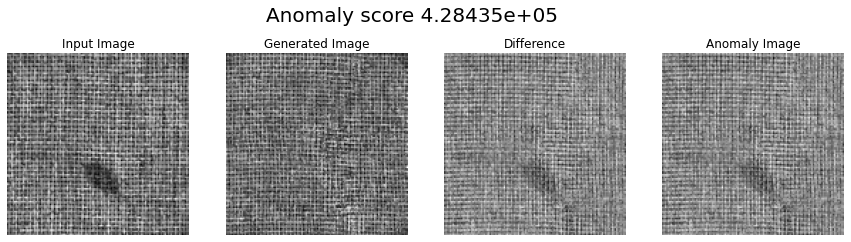

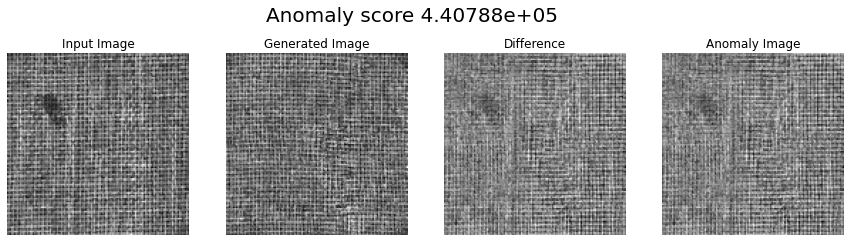

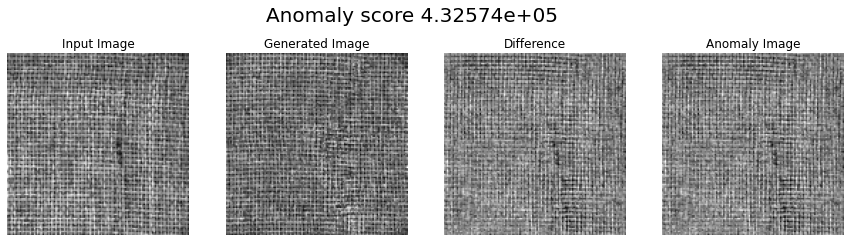

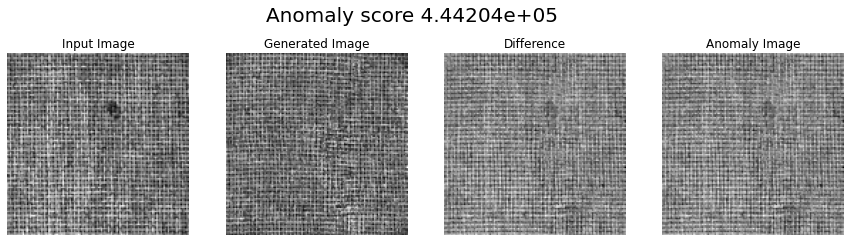

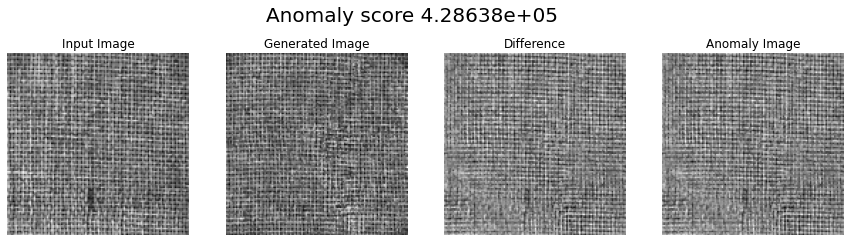

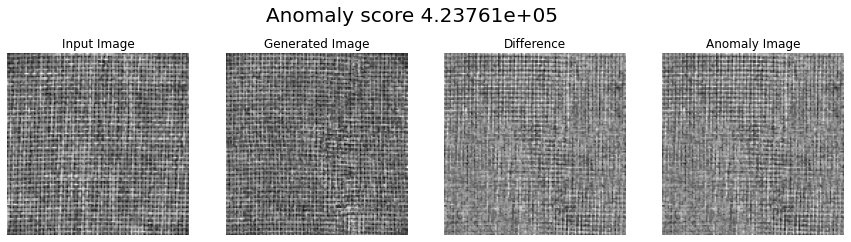

In [65]:
show_image_score(test_set, latent_space)